In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [1]:
! ls ../data/intermediate/embedding/tile2vec-v2/version_1/checkpoints

epoch=1-step=4500.ckpt
epoch=1-step=5286.ckpt


In [3]:
from birdclef.models.embedding.tilenet import TileNet

model = TileNet.load_from_checkpoint(
    "../data/intermediate/embedding/tile2vec-v2/version_1/checkpoints/"
    "epoch=1-step=5286.ckpt",
    z_dim=64,
)
model

stft hop length 2474
STFT kernels created, time used = 0.7998 seconds
STFT filter created, time used = 0.0452 seconds
Mel filter created, time used = 0.0452 seconds
MelSpectrogram(
  Mel filter banks size = (64, 2049), trainable_mel=True
  (stft): STFT(n_fft=4096, Fourier Kernel size=(2049, 1, 4096), iSTFT=False, trainable=False)
)


TileNet(
  (spec_layer): MelSpectrogram(
    Mel filter banks size = (64, 2049), trainable_mel=True
    (stft): STFT(n_fft=4096, Fourier Kernel size=(2049, 1, 4096), iSTFT=False, trainable=False)
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=

In [4]:
import pandas as pd

df = pd.read_parquet("../data/intermediate/2022-02-26-motif-consolidated.parquet")
df

source_name  cens_sample_rate  \
0      train_audio/afrsil1/XC125458.ogg                10   
1      train_audio/afrsil1/XC175522.ogg                10   
2      train_audio/afrsil1/XC177993.ogg                10   
3      train_audio/afrsil1/XC205893.ogg                10   
4      train_audio/afrsil1/XC207431.ogg                10   
...                                 ...               ...   
14847   train_audio/zebdov/XC629769.ogg                10   
14848   train_audio/zebdov/XC642415.ogg                10   
14849   train_audio/zebdov/XC665873.ogg                10   
14850   train_audio/zebdov/XC666194.ogg                10   
14851   train_audio/zebdov/XC666195.ogg                10   

       matrix_profile_window  motif_0  motif_1  sample_rate  duration_cens  \
0                         50     61.0     26.0        22050            113   
1                         50    229.0    305.0        22050            477   
2                         50    492.0    353.0        22050            545   
3                         50    397.0    726.0        22050           1069   
4                         50      NaN      NaN        22050             35   
...                      ...      ...      ...          ...            ...   
14847                     50    362.0    326.0        22050            619   
14848                     50      0.0     25.0        22050            151   
14849                     50    397.0    365.0        22050            462   
14850                     50    169.0    133.0        22050            219   
14851                     50    124.0     71.0        22050            400   

       duration_samples  duration_seconds  
0                244800             11.10  
1               1036800             47.02  
2               1185408             53.76  
3               2325888            105.48  
4                 74880              3.40  
...                 ...               ...  
14847           1346285             61.06  
14848            327575             14.86  
14849           1004951             45.58  
14850            475200             21.55  
14851            869741             39.44  

[14852 rows x 9 columns]

In [6]:
df["species"] = df.source_name.apply(lambda x: x.split("/")[1])
df[["species"]].groupby("species").size().sort_values(ascending=False)

species
brnowl     500
skylar     500
norcar     500
mallar3    500
houspa     500
          ... 
puaioh       3
layalb       3
akikik       2
crehon       2
maupar       1
Length: 152, dtype: int64

## intraclass clustering and comparison

In [8]:
from birdclef.workflows import motif
from pathlib import Path

data = []
root = Path("../data/raw/birdclef-2022")
for row in df[df.species == "brnowl"].sample(50).itertuples():
    y = motif._load_audio(root / row.source_name, int(row.motif_0), 5)
    data.append(y)
data[0]

array([0.01370447, 0.01330185, 0.0136336 , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

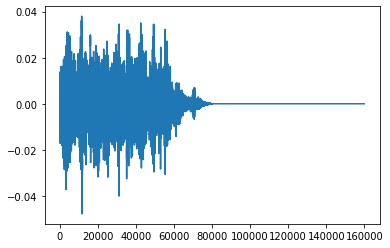

In [10]:
import IPython.display as ipd
import matplotlib.pyplot as plt

z = data[0]
plt.plot(z)
plt.show()
ipd.Audio(z, rate=32000)

In [23]:
import numpy as np
np.array(data).shape

(50, 160000)

In [26]:
import torch

emb = model(torch.from_numpy(np.array(data))).detach().numpy()
print(emb[:3])

[[1.5262711  4.5002766  3.9256887  1.0065371  2.2860434  1.7738862
  4.957777   5.0078573  1.7602328  1.7297746  0.19743004 0.10979635
  1.2101711  6.262855   2.8699725  1.5436149  1.5161607  0.73278683
  7.977792   0.38751337 1.0492957  2.3084679  2.34505    1.3832654
  5.6876197  2.715371   0.39252627 4.172232   0.         1.3844844
  2.8480003  0.37176955 2.0623467  3.5280557  0.         0.13535433
  3.1754196  4.2073836  2.9635472  0.9665564  0.30805415 0.3905187
  4.3793173  0.7376878  2.557347   0.86431575 1.5293616  0.205531
  1.5475928  0.59075105 1.9043087  1.7834686  1.3664156  2.7152872
  1.0038679  2.1849551  0.02833182 2.2834187  2.6984901  5.8439474
  4.514917   2.0278108  2.1188264  5.016532  ]
 [1.1384265  4.4248705  3.986722   1.2746682  2.2490978  2.163728
  4.9983735  5.1337004  1.8546532  1.778932   0.08758716 0.7466364
  1.2536676  2.7239707  0.22378181 2.279755   1.9797621  0.6633123
  1.0308969  1.7632251  0.8980492  2.2295642  2.9620204  2.4004426
  3.2679513  2

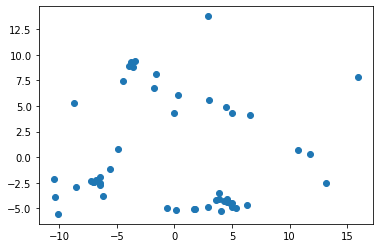

In [30]:
from sklearn.decomposition import PCA

g = PCA(n_components=2).fit_transform(emb)
plt.scatter(g[:,0], g[:,1])

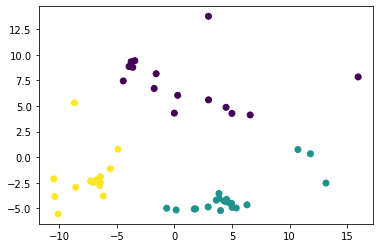

In [37]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3).fit(emb)
kmeans.labels_
plt.scatter(g[:,0], g[:,1], c=kmeans.labels_)

In [48]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors().fit(emb)
dist, neighbors = nn.kneighbors(kmeans.cluster_centers_, 3)
dist

array([[4.0845823, 4.3750114, 4.8132153],
       [1.7050412, 1.7156627, 1.8415824],
       [1.9494302, 2.815232 , 2.8335555]], dtype=float32)

In [47]:
for gid, group in enumerate(neighbors):
    print(f"group {gid}")
    for idx in group:
        ipd.display(ipd.Audio(data[idx], rate=32000))

group 0


group 1


group 2


## interclass clustering and comparison

In [64]:
data = []
root = Path("../data/raw/birdclef-2022")
labels = []
for row in df[df.species.isin(["brnowl", "skylar", "norcar"])].sample(300).itertuples():
    y = motif._load_audio(root / row.source_name, int(row.motif_0), 5)
    data.append(y)
    labels.append(row.species)
data[0], labels[0]

(array([0.00181633, 0.0018803 , 0.00314776, ..., 0.        , 0.        ,
        0.        ], dtype=float32),
 'norcar')

In [65]:
from collections import Counter
Counter(labels)

Counter({'norcar': 90, 'skylar': 101, 'brnowl': 109})

0 class norcar


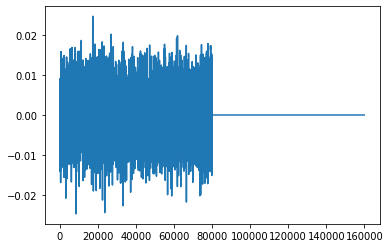

1 class skylar


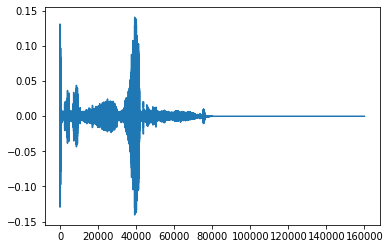

2 class brnowl


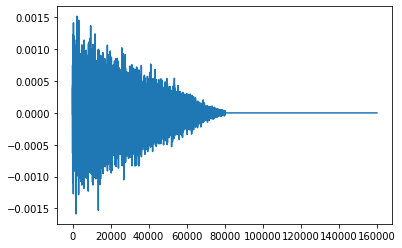

In [66]:
for i in range(3):
    print(f"{i} class {labels[i]}")
    z = data[i]
    plt.plot(z)
    plt.show()
    ipd.display(ipd.Audio(z, rate=32000))

In [69]:
emb = model(torch.from_numpy(np.array(data))).detach().numpy()

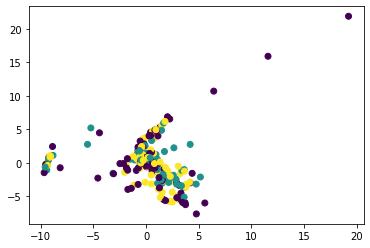

In [70]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(labels)

g = PCA(n_components=2).fit_transform(emb)
plt.scatter(g[:,0], g[:,1], c=le.transform(labels))

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(g, le.transform(labels), test_size=0.33)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

0.26262626262626265